In this notebook, we solve the Laplace equation in 2D grid, with verification to the original solution, and do a benchamark analysis of how the different parallization techniques scale

The equation to solve is $\nabla^2 u$ = 0.

# Open MPI
First look at Open MPI, relatively easy to implement with #pragma directive

In [8]:
%%writefile omp_laplace.c
#include<stdio.h>
#include "omp.h"
#include<math.h>
#include<stdlib.h>
#include<time.h>

#define Lx 1
#define Ly 1
#define PI M_PI

int main(int argc, char *argv[]){
    if(argc < 1){
      printf("Please provide input about the number of threads\n");
      exit(1);
    }
    // Read the inputs, can add error checks
    int NUM_THREADS = atoi(argv[1]);
    int Nx = atoi(argv[2]);
    int Ny = atoi(argv[3]);
    printf("Nx: %d, Ny: %d, NUM_THREADS:%d\n",Nx, Ny,NUM_THREADS);

    FILE *fout;
    fout = fopen("omp_output_details.txt", "w");


    double t_start, t_end;

    // set the parallel variables
    omp_set_dynamic(0);
    omp_set_num_threads(NUM_THREADS);

    //Initialize the 2D grid
    double field[Ny][Nx], new_field[Ny][Nx];
    double h = ((double) Lx)/(Nx-1);
    int i, j;
    FILE *fp;
    fp = fopen("omp_output_visual.txt", "w");
    for(i=0;i<Nx;i++){
        for(j=0;j<Ny;j++) {
            field[j][i] = 0.0;
        }
    }
    // Boundary Conditions
    for(i=0, j=0; j<Ny; j++) field[j][i] = 0; //left boundary
    for(i=Nx-1, j=0; j<Ny; j++) field[j][i] = 0; //right boundary
    for(i=0, j=0; i<Nx; i++) field[j][i] = sin(PI*(i)*h); // top boundary
    for(i=0, j=Ny-1; i<Nx; i++) field[j][i] = sin(PI*i*h)*exp(-j*h*PI); //bottom boundary

    for(i=0;i<Nx;i++){
        for(j=0;j<Ny;j++) {
            new_field[j][i] = field[j][i];
        }
    }
    double totalerror=1;
    double convergence_criteria = 1e-6;
    int iter=0;
    t_start = omp_get_wtime();
    while(totalerror > convergence_criteria){
        totalerror = 0;
        #pragma omp parallel for collapse(2) num_threads(NUM_THREADS) schedule(auto) shared(field, new_field) reduction(+: totalerror)
        for(i=1;i<Nx-1;i++){
            for(j=1;j<Ny-1;j++){
                new_field[j][i] = (field[j][i+1] + field[j][i-1] + field[j+1][i] + field[j-1][i])/(4.0);
                totalerror += fabs(new_field[j][i] - field[j][i]);
            }
        }
        iter += 1;
        for(i=0;i<Nx;i++) for(j=0;j<Ny;j++) field[j][i] = new_field[j][i];
    }
    t_end = omp_get_wtime();

    for(j=0;j<Ny;j++){
        for(i=0;i<Nx;i++){
            fprintf(fp, "%lf ", field[j][i]);
        }
        fprintf(fp, "\n");
    }

    //Calculate the error from the actual solution
    float er;
    for(j=0;j<Ny;j++){
      for(i=0;i<Nx;i++){
        er += (field[j][i] - sin(PI*i*h)*exp(-PI*j*h))*(field[j][i] - sin(PI*i*h)*exp(-PI*j*h));
      }
    }
    fprintf(fout, "%d %d %le %le\n", NUM_THREADS, iter, t_end - t_start, (t_end-t_start)/iter);
    printf("NTHREADS: %d, iterations: %d, N: %d, Time: %le sec, Time_per_iteration: %le sec, Error:%le\n", NUM_THREADS, iter, Nx*Ny, t_end-t_start, (t_end-t_start)/iter, er);
    fclose(fp);
    fclose(fout);

    return 0;
}

Writing omp_laplace.c


In [9]:
%%shell
gcc -fopenmp omp_laplace.c -o omp_output -lm

In [10]:
%%shell
./omp_output 4 128 128

Nx: 128, Ny: 128, NUM_THREADS:4
NTHREADS: 4, iterations: 43814, N: 16384, Time: 1.309971e+01 sec, Time_per_iteration: 2.989845e-04 sec, Error:1.209582e-06


In [ ]:
%%shell
for i in 1 2 4 8 16
do
  ./omp_output $i 128 128
done

Nx: 128, Ny: 128, NUM_THREADS:1
NTHREADS: 1, iterations: 43814, N: 16384, Time: 6.994939e+00 sec, Time_per_iteration: 1.596508e-04 sec, Error:1.209582e-06
Nx: 128, Ny: 128, NUM_THREADS:2
NTHREADS: 2, iterations: 43814, N: 16384, Time: 7.685709e+00 sec, Time_per_iteration: 1.754167e-04 sec, Error:1.209582e-06
Nx: 128, Ny: 128, NUM_THREADS:4
NTHREADS: 4, iterations: 43814, N: 16384, Time: 9.888225e+00 sec, Time_per_iteration: 2.256864e-04 sec, Error:1.209582e-06
Nx: 128, Ny: 128, NUM_THREADS:8
NTHREADS: 8, iterations: 43814, N: 16384, Time: 1.112623e+01 sec, Time_per_iteration: 2.539423e-04 sec, Error:1.209582e-06
Nx: 128, Ny: 128, NUM_THREADS:16
NTHREADS: 16, iterations: 43814, N: 16384, Time: 1.273509e+01 sec, Time_per_iteration: 2.906626e-04 sec, Error:1.209582e-06


The time increases with the numer of threads. Cloud system, the time for each iteration is also different. Ran once - the time with 4 threads is 13 s, whereas next time it is 9.8 s.

In my laptop, 6-core i5 AMD proc - it takes 3.67 s for 1 thread, 2.58 s with 2 threads, 2.29 s with 4 threads

# MPI

Now we will do an MPI implementation considering only row-based division, i.e. each processor handles smaller sections of the grids with Nx columns and Ny/num_procs rows.

In [11]:
%%writefile mpi_laplace.c

#include<stdio.h>
#include"mpi.h"
#include<math.h>
#include<stdlib.h>


#define Nx 128
#define Ny 128
#define Lx 1
#define Ly 1
#define PI M_PI

#define MASTER 0

int main(){

    int rank, size;
    MPI_Status status;
    MPI_Init(NULL, NULL);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    int self, up, down;
    self = rank;
    FILE *fout;
    fout = fopen("mpi_output_details.txt", "w");

    float t_start, t_end;
    //printf("Size:%d, rank:%d, Nx:%d\n", size, rank, Nx);

    // Periodic boundary condition
    //    up = rank+1>size-1? rank+1-size: rank+1;
    //    down = rank-1<0? rank-1+size: rank-1;

    // Fixed boundary condition
    down = rank+1 > size-1? -1: rank+1;
    up = rank-1<0? -1: rank-1;

    //printf("Self:%d, up:%d, down:%d\n", self, up, down);
    int i, j;
    float h = ((float) Lx)/(Nx-1);
    int rows_per_proc = (int) (Ny/size);
    int base;

    //proc_field is a halo region with communication layers
    float proc_field[rows_per_proc+2][Nx], new_proc_field[rows_per_proc+2][Nx];
    float field[Ny][Nx];



    // Use the master proc to organize and distribute the data
    if (self == 0){
        //Initialize
        for (j=0; j<Ny; j++){
            for (i=0; i<Ny; i++){
                field[j][i] = 0;
            }
        }

        //boundary condition
        for(i=0, j=0; j<Ny; j++) field[j][i] = 0; //left boundary
        for(i=Nx-1, j=0; j<Ny; j++) field[j][i] = 0; //right boundary
        for(i=0, j=0; i<Nx; i++) field[j][i] = sin(PI*(i)*h); // top boundary
        for(i=0, j=Ny-1; i<Nx; i++) field[j][i] = sin(PI*i*h)*exp(-j*h*PI); //bottom boundary


        // Keep one chunk for itself, and distribute the rest to individual procs
        for(i=1; i<size; i++){
            base = i*rows_per_proc;
            MPI_Send(&base, 1, MPI_INT, i, 0, MPI_COMM_WORLD);
            MPI_Send(&field[base][0], Nx*rows_per_proc, MPI_FLOAT, i, 0, MPI_COMM_WORLD);
        }
        // Only the lowest block
        for(j=1; j<rows_per_proc+1; j++){
            for (i=0; i<Nx; i++) {
                proc_field[j][i] = field[j-1][i];
                new_proc_field[j][i] = proc_field[j][i];
            }
        }
    }
    else{
        MPI_Recv(&base, 1, MPI_INT, MASTER, 0, MPI_COMM_WORLD, &status);
        MPI_Recv(&proc_field[1][0], Nx*rows_per_proc, MPI_FLOAT, MASTER, 0, MPI_COMM_WORLD, &status);
    }

    // Perform Computation

    float localerror;
    int iter;
    float convergence_criteria = 1e-6;
    float totalerror=1;
    float er;

    t_start = MPI_Wtime();
    int start, end;
    while(totalerror > convergence_criteria){
        localerror = 0.;
        if(down == -1){
            //bottom slab
            MPI_Send(&proc_field[1][0], Nx, MPI_FLOAT, up, 1, MPI_COMM_WORLD);

            MPI_Recv(&proc_field[0][0], Nx, MPI_FLOAT, up, 1, MPI_COMM_WORLD, &status);

            start = 1;
            end = rows_per_proc;
        }
        else if(up == -1){
            //top slab
            MPI_Send(&proc_field[rows_per_proc][0], Nx, MPI_FLOAT, down, 1, MPI_COMM_WORLD);

            MPI_Recv(&proc_field[rows_per_proc+1][0], Nx, MPI_FLOAT, down, 1, MPI_COMM_WORLD, &status);

            start = 2;
            end = rows_per_proc+1;
        }
        else{
            MPI_Recv(&proc_field[0][0], Nx, MPI_FLOAT, up, 1, MPI_COMM_WORLD, &status);

            MPI_Send(&proc_field[1][0], Nx, MPI_FLOAT, up, 1, MPI_COMM_WORLD);

            MPI_Send(&proc_field[rows_per_proc][0], Nx, MPI_FLOAT, down, 1, MPI_COMM_WORLD);

            MPI_Recv(&proc_field[rows_per_proc+1][0], Nx, MPI_FLOAT, down, 1, MPI_COMM_WORLD, &status);

            start = 1;
            end = rows_per_proc+1;
        }



        for (i=1; i<Nx-1; i++){
            for(j=start; j<end; j++){
                new_proc_field[j][i] = (proc_field[j][i+1] + proc_field[j][i-1] +
                                    proc_field[j+1][i] + proc_field[j-1][i])/(4.0);
                localerror += fabs(new_proc_field[j][i] - proc_field[j][i]);
            }
        }
        iter+=1;
        for(i=0;i<Nx;i++) for(j=start;j<end;j++) proc_field[j][i] = new_proc_field[j][i];

        MPI_Reduce(&localerror, &totalerror, 1, MPI_FLOAT, MPI_SUM, MASTER, MPI_COMM_WORLD);
        //MPI_Barrier(MPI_COMM_WORLD);
        //if(self==MASTER) printf("Iteration=%d, totalerror=%le\n", iter, totalerror);
        MPI_Bcast(&totalerror, 1, MPI_FLOAT, 0, MPI_COMM_WORLD);
        //printf("Rank %d\n", self);
    }


    if (self == 0){
        for (i=1; i<size; i++) {
            base = i*rows_per_proc;
            MPI_Recv(&field[base][0], Nx*rows_per_proc, MPI_FLOAT, i, 1, MPI_COMM_WORLD, &status);
        }
        // new_proc_field to field copy
        for(j=1; j<rows_per_proc+1; j++){
            for (i=0; i<Nx; i++) {
                field[j-1][i] = proc_field[j][i];
            }
        }
        FILE *fp;
        fp = fopen("output_mpi2.txt", "w");
        for(j=0;j<Ny;j++){
            for(i=0;i<Nx;i++){
                fprintf(fp, "%lf ", field[j][i]);
            }
            fprintf(fp, "\n");
        }
        fclose(fp);



    }
    else{
        MPI_Send(&proc_field[1][0], Nx*rows_per_proc, MPI_FLOAT, 0, 1, MPI_COMM_WORLD); // Send the new_proc_field data to field copy in master
    }
    t_end = MPI_Wtime();
    if(self==MASTER){
        //Verify the computations

        for(j=0;j<Ny;j++){
            for(i=0;i<Nx;i++){
                er += (field[j][i] - sin(PI*i*h)*exp(-PI*j*h))*(field[j][i] - sin(PI*i*h)*exp(-PI*j*h));
            }

        }
        //printf("Error from analytic solution: %le\n", er);
        MPI_Bcast(&er, 1, MPI_FLOAT, 0, MPI_COMM_WORLD);
    }

    if(self==MASTER){
      printf("NPROCS: %d, iterations: %d, N: %d, Time: %le sec, Time_per_iteration: %le sec, Error:%le\n", size, iter, Nx*Ny, t_end-t_start, (t_end-t_start)/iter, er);
      //printf("Total running time with %d processes for %d iterations= %le\n", size, iter, end_time-start_time);
    }
    MPI_Finalize();

    return 0;
}

Writing mpi_laplace.c


In [12]:
%%shell
mpicc mpi_laplace.c -o mpi_output -lm

In [13]:
%%shell
mpiexec -np 4 --allow-run-as-root --oversubscribe ./mpi_output

NPROCS: 4, iterations: 34282, N: 16384, Time: 8.990182e+00 sec, Time_per_iteration: 2.622420e-04 sec, Error:1.023988e-07


In [ ]:
%%shell
for i in 2 4 8 16
do
  mpiexec -np $i --allow-run-as-root --oversubscribe ./mpi_output
done

NPROCS: 2, iterations: 34282, N: 16384, Time: 4.790731e+00 sec, Time_per_iteration: 1.397448e-04 sec, Error:1.023988e-07
NPROCS: 4, iterations: 34282, N: 16384, Time: 7.045597e+00 sec, Time_per_iteration: 2.055188e-04 sec, Error:1.023988e-07
NPROCS: 8, iterations: 34282, N: 16384, Time: 9.171598e+00 sec, Time_per_iteration: 2.675339e-04 sec, Error:1.023988e-07
NPROCS: 16, iterations: 35348, N: 16384, Time: 2.722828e+01 sec, Time_per_iteration: 7.702921e-04 sec, Error:inf


Similar to OpenMPI, the time increases with number of processors probably due to cloud resources.

In my laptop, it takes, 2.36 s for 2 processors, and 1.37 s for 4 processors respectively.

**Shows better scaling with MPI atleast for few processors**

# CUDA - GPU acceleration

In [31]:
# GPU
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-qqdmm3au
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-qqdmm3au
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done


In [32]:
%load_ext nvcc_plugin

The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


In [25]:
%%writefile cuda_laplace.cu


#include<stdio.h>
#include<math.h>
#include<stdlib.h>

//Enter in multiples of 64
#define Nx 128
#define Ny 128
#define PI 3.14159

#define THREADS_PER_BLOCK 512

inline
cudaError_t checkCuda(cudaError_t result)
{
#if defined(DEBUG) || defined(_DEBUG)
  if (result != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime Error: %s\n", cudaGetErrorString(result));
    assert(result == cudaSuccess);
  }
#endif
  return result;
}


__global__ void update(float *d_f, float *d_nf){
  __shared__ float halo[(THREADS_PER_BLOCK/Nx + 2)*Nx];

  int global_index = threadIdx.x + blockIdx.x * blockDim.x;
  int local_index = threadIdx.x + Nx;
  halo[local_index] = d_f[global_index];

  int N = Nx*Ny;

  //handle the halo
  if(threadIdx.x < Nx){
    if(blockIdx.x != 0){
      halo[local_index - Nx] = d_f[global_index - Nx]; //top halo
    }
  }
  if(threadIdx.x > THREADS_PER_BLOCK - Nx){
    if(global_index < N - Nx){
      halo[local_index + Nx] = d_f[global_index + Nx];
    }
  }
  __syncthreads();

  //handle the boundary conditions
  int i;
  int flag_boundary = 0;
  for (i = 0; i<THREADS_PER_BLOCK/Nx; i++){
    if((threadIdx.x == i*Nx) || (threadIdx.x == (i+1)*Nx - 1)){
      //left boundary and right boundary
      d_nf[global_index] = d_f[global_index];
      flag_boundary = 1;
      continue;
    }
  }
  if((global_index - Nx < 0) || (global_index + Nx > N)){
      //top and bottom boundary
      d_nf[global_index] = d_f[global_index];
      flag_boundary = 1;
  }

  // Compute the Jacobi iteration
  if(flag_boundary == 0){
    d_nf[global_index] = (halo[local_index + 1] + halo[local_index - 1] + halo[local_index + Nx] + halo[local_index - Nx])/(4.0);
    //if(index%10 == 5) printf("Running from thread: %d, xid=%d, yid=%d, prev_value=%lf, new_value=%lf\n", index, xid, yid, d_f[index], d_nf[index]);
  }
}


float calc_total_error(float *f, float *nf, int N){
  float er = 0;
  for(int i=0; i<N; i++) er += fabs(nf[i] - f[i]);
  return er;
}

int main(){
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    float *field, *new_field;
    int N = Nx*Ny;

    int i, j;
    int size = N*sizeof(float);
    float h = (1.0)/(Nx-1);

    //allocate memory and initialize
    field = (float *)malloc(size);
    new_field = (float *)malloc(size);

    int index;
    for(i=0; i<N; i++) field[i] = 0.0;
    //Adding boundary conditions

    for(i=0, j=0; j<Ny; j++) {index=j*Nx+i;field[index] = 0;} //left boundary
    for(i=Nx-1, j=0; j<Ny; j++) {index=j*Nx+i;field[index] = 0;} //right boundary
    for(i=0, j=0; i<Nx; i++) {index=j*Nx+i;field[index] = sin(PI*(i)*h);} // top boundary
    for(i=0, j=Ny-1; i<Nx; i++) {index=j*Nx+i;field[index] = sin(PI*i*h)*exp(-j*h*PI);} //bottom boundary
    for(i=0; i<N; i++) new_field[i] = field[i];


    float *d_field, *d_new_field;
    checkCuda(cudaMalloc((void **)&d_field, size));
    checkCuda(cudaMalloc((void **)&d_new_field, size));

    float totalerror = 1.0;
    float convergence_criteria = 1e-6;
    int iter = 0;
    cudaEventRecord(start);
    while(totalerror > convergence_criteria){
      checkCuda(cudaMemcpy(d_field, field, size, cudaMemcpyHostToDevice));
      update<<<(N + THREADS_PER_BLOCK - 1)/THREADS_PER_BLOCK, THREADS_PER_BLOCK>>>(d_field, d_new_field);
      checkCuda(cudaMemcpy(new_field, d_new_field, size, cudaMemcpyDeviceToHost));

      totalerror = calc_total_error(field, new_field, N);
//      if(iter%1000==0) printf("Iteration : %d, error: %lf\n", iter, totalerror);
      for(i=0; i<N; i++) field[i]=new_field[i];
      iter+= 1;
    }
    cudaEventRecord(stop);
    //cudaEventSynchronize(stop);
    cudaFree(d_field); cudaFree(d_new_field);
    /*
    for(j=0;j<Ny; j++){
        for(i=0;i<Nx;i++){
          index = j*Nx + i;
            printf("%lf ", field[index]);
        }
        printf("\n");
    }
    */
    FILE *fp;
    fp = fopen("output_cuda2.txt", "w");
    for(j=0;j<Ny;j++){
        for(i=0;i<Nx;i++){
          index = j*Nx + i;
          fprintf(fp, "%lf ", field[index]);
        }
        fprintf(fp, "\n");
    }
    fclose(fp);
    //Error from analytical solution
    float er=0;
    for(j=0;j<Ny;j++){
      for(i=0;i<Nx;i++){
        index = j*Nx + i;
        er += (field[index] - sin(PI*i*h)*exp(-PI*j*h))*(field[index] - sin(PI*i*h)*exp(-PI*j*h));
      }
    }
    float milliseconds;
    cudaEventElapsedTime(&milliseconds, start, stop);
    printf("iterations: %d, N: %d, Time: %le sec, Time_per_iteration: %le sec, Error:%le\n",  iter, Nx*Ny, 0.001*milliseconds, (0.001*milliseconds)/iter, er);

    free(field); free(new_field);


    return 0;
}

Overwriting cuda_laplace.cu


In [26]:
%%shell
nvcc cuda_laplace.cu -lm
./a.out

iterations: 34136, N: 16384, Time: 5.686182e+00 sec, Time_per_iteration: 1.665743e-04 sec, Error:1.210029e-07


Using the same setup of Google Collab, GPU provides a 2x speedup from OpenMP and 1.5x from MPI parallelization considering 4 threads and 4 processors respectively.

In [28]:
!nvidia-smi

Mon Jun 19 00:03:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Verification between different parallel execution

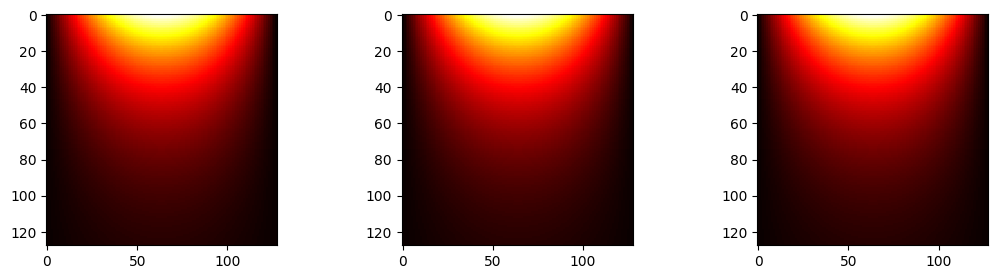

In [20]:
import matplotlib.pyplot as plt
import numpy as np


fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)
filename = 'omp_output_visual.txt'
temperature = np.loadtxt(filename)
ax1.imshow(temperature, interpolation='nearest', cmap='hot')

filename = 'output_mpi2.txt'
temperature = np.loadtxt(filename)
ax2.imshow(temperature, interpolation='nearest', cmap='hot')

filename = 'output_cuda2.txt'
temperature = np.loadtxt(filename)
ax3.imshow(temperature, interpolation='nearest', cmap='hot')

plt.show()


| Parallel Type | System Size | Units | Total Time | Time per iteration |
| ------------- | ----------- | ----- | ---------- | ------------------ |
|     Open MP   |  128 X 128  | 4 Threads | 13.1 s |       2.98e-4      |
|       MPI     |  128 X 128  | 4 Procs   | 8.9 s  |       2.62e-4      |
|     GPU   |  128 X 128  | 512 Th/block + 32 Blocks | 5.68 s |       1.66e-4      |



# Conclusions

- For same setup of Google Collab, GPU provides a speedup of 2x from OpenMPI with 4 threads, and 1.5x from MPI implementation with 4 procs.
- Huge difference in execution time between laptop and google collab, but the scaling is consistent between OpenMP and MPI, e.g. OpenMP (on average) takes 11 s to finish with 4 threads on GoogleCollab and 2.3 s on my laptop, similarly MPI takes 7 s wit 4 procs on GoogleCollab and 1.37 s on my laptop. Donot have GPU on laptop, and cannot benchmark GoogleCollab with desktop.
- GPU acceleration is not optimized with respect to architecture but still provides a speedup